In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

In [2]:
''' train and test path '''
train_path = '../input/audio-cats-and-dogs/cats_dogs/train'
test_path = '../input/audio-cats-and-dogs/cats_dogs/test'

In [3]:
''' reading audio files '''
train_f = tf.io.gfile.glob(train_path + '/*/*')
train_f = tf.random.shuffle(train_f)
train_ds = train_f

test_f = tf.io.gfile.glob(test_path + '/*/*')
test_f = tf.random.shuffle(test_f)
test_ds = test_f

''' shape of trian_ds and test_ds '''
print(train_ds.shape)
print(test_ds.shape)

(210,)
(67,)


In [4]:
def waveform_lbl(f):
    
    l = tf.strings.split(f, os.path.sep)[-2]
    audio = tf.io.read_file(f)
    aud, _ = tf.audio.decode_wav(audio)
    wv = tf.squeeze(aud, axis=-1)
    return wv, l

''' AUTOTUNE '''
AUTO = tf.data.AUTOTUNE

''' input pipeline '''
ds = tf.data.Dataset.from_tensor_slices(train_ds)
wv_ds = ds.map(waveform_lbl, num_parallel_calls=AUTO)

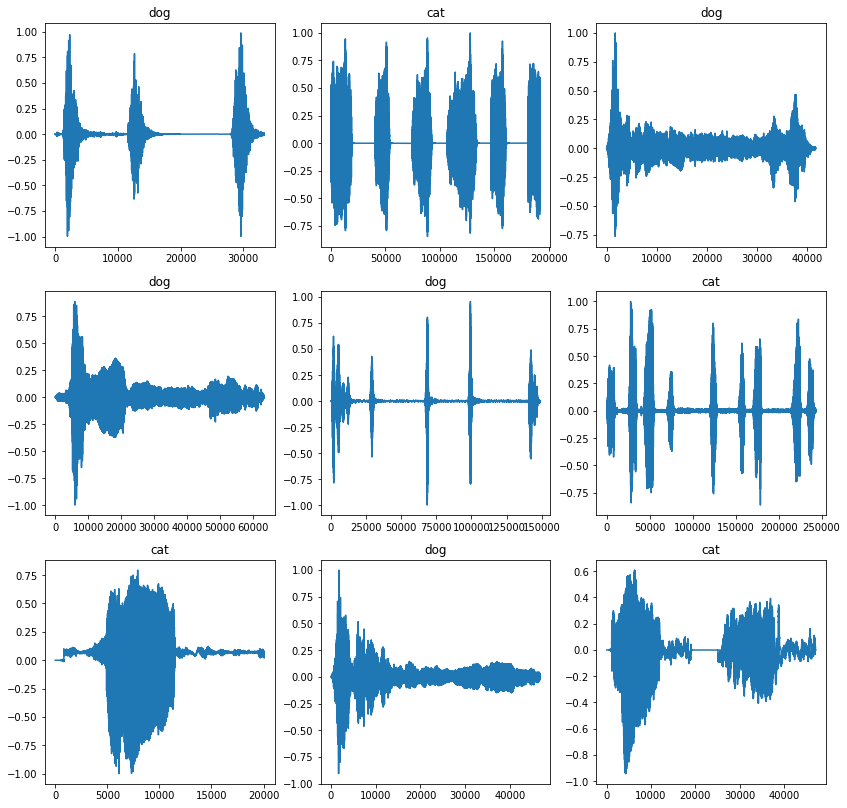

In [5]:
for i, (aud, lbl in enumerate(wv_ds.take(3*3)):
    fig, axs = plt.subplots(3,3,figsize=(14,14))
    r = i//3
    c = i%3
    ax = axs[r][c]
    ax.plot(aud.numpy())
    label = lbl.numpy().decode('utf-8')
    ax.set_title(lbl)

plt.show()

In [6]:
def spec_lbl(aud, lbl):

    pad = tf.zeros([300000]-tf.shape(audio), dtype=tf.float32)
    wave = tf.cast(aud, tf.float32)
    eq_len = tf.concat([wave, pad], 0)
    spec = tf.signal.stft(eq_len, frame_length=210, frame_step=110)    
    spec = tf.abs(spec)
    spec = tf.expand_dims(spec, -1)
    lbl_id = tf.argmax(lbl == labels)
    return spec, lbl_id

name = ["cat","dog","test"]
labels = np.array(name)
spec_ds = wv_ds.map(spec_lbl, num_parallel_calls=AUTO)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  


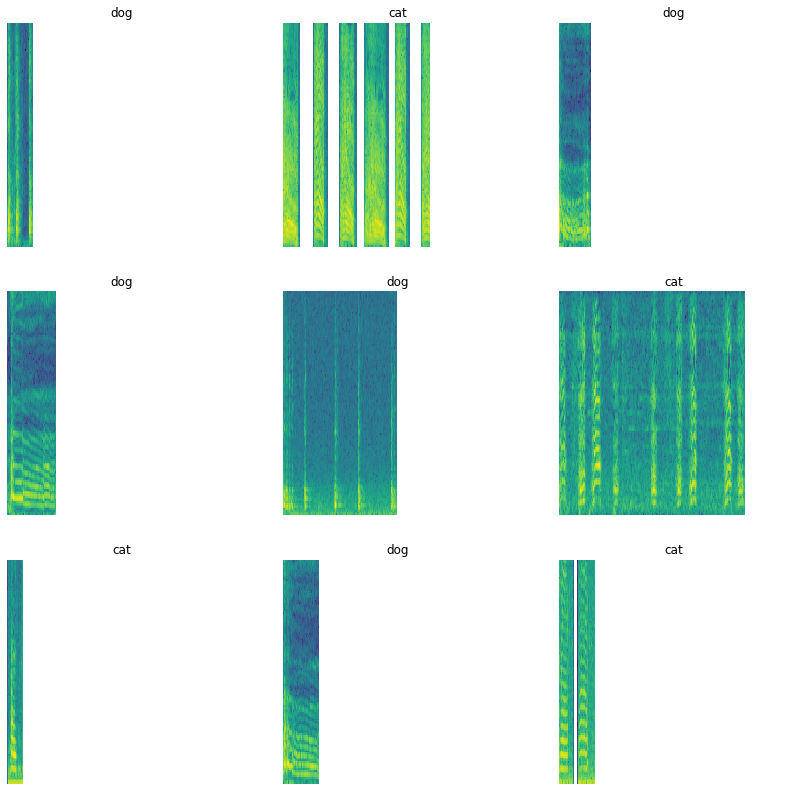

In [7]:
def plot_spec(spec, ax):
    log_sp = np.log(spec.T)
    h = log_sp.shape[0]
    w = log_spec.shape[1]
    X = np.linspace(0, np.size(spec), num=w, dtype=int)
    y = range(h)
    ax.pcolormesh(X, y, log_sp)

for i, (spec, lbl_id) in enumerate(spec_ds.take(3*3)):
    fig, ax = plt.subplots(3,3, figsize=(14,14))
    r = i//3
    c = i%3
    ax = ax[r][c]
    plot_spec(np.squeeze(spec.numpy()), ax)
    ax.set_title(labels[lbl_id.numpy()])
    ax.axis('off')
    
plt.show()

In [8]:
def pre_process(file):
    
    ds = tf.data.Dataset.from_tensor_slices(file)
    output = ds.map(waveform_lbl, num_parallel_calls=AUTO)
    output = output.map(spec_lbl, num_parallel_calls=AUTO)
    return output

train_ds = spec_ds
test_ds = pre_process(test_ds)

In [9]:
''' initalizing batch size '''
batch_size = 64
train_ds = train_ds.batch(batch_size)
train_ds = train_ds.cache().prefetch(AUTO)

In [10]:
for sp,_ in spec_ds.take(1):
    inp_shape = sp.shape

num_lbl = len(labels)
norm = preprocessing.Normalization()
norm.adapt(spec_ds.map(lambda x, _: x))

''' shape of input '''
print(inp_shape)
print(num_lbl)

(2726, 129, 1)
3


In [11]:
''' model '''
model = models.Sequential([
    layers.Input(shape=input_shape),
    preprocessing.Resizing(32, 32), 
    norm_layer,
    layers.Conv2D(32,3, activation='relu'),
    layers.Dropout(0.2),
    layers.Conv2D(128,3, activation='relu'),
    layers.Dropout(0.2),    
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(16, activation='relu'),
    layers.Dense(num_labels),
])

''' lets see how model looks like '''
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing (Resizing)          (None, 32, 32, 1)         0         
_________________________________________________________________
normalization (Normalization (None, 32, 32, 1)         3         
_________________________________________________________________
conv2d (Conv2D)              (None, 30, 30, 32)        320       
_________________________________________________________________
dropout (Dropout)            (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 128)       36992     
_________________________________________________________________
dropout_1 (Dropout)          (None, 28, 28, 128)       0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 128)       0

In [12]:
''' compile the model '''
model.compile(optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [13]:
epochs = 30
''' training '''
history = model.fit(train_ds,epochs=epochs)

Epoch 1/30
4/4 [==============================] - 9s 1s/step - loss: 0.9906 - accuracy: 0.3768
Epoch 2/30
4/4 [==============================] - 1s 188ms/step - loss: 0.5376 - accuracy: 0.7470
Epoch 3/30
4/4 [==============================] - 1s 180ms/step - loss: 0.4718 - accuracy: 0.7928
Epoch 4/30
4/4 [==============================] - 1s 191ms/step - loss: 0.3891 - accuracy: 0.8656
Epoch 5/30
4/4 [==============================] - 1s 190ms/step - loss: 0.3588 - accuracy: 0.8384
Epoch 6/30
4/4 [==============================] - 1s 184ms/step - loss: 0.3137 - accuracy: 0.8696
Epoch 7/30
4/4 [==============================] - 1s 183ms/step - loss: 0.2656 - accuracy: 0.8904
Epoch 8/30
4/4 [==============================] - 1s 188ms/step - loss: 0.2320 - accuracy: 0.9193
Epoch 9/30
4/4 [==============================] - 1s 182ms/step - loss: 0.2160 - accuracy: 0.9155
Epoch 10/30
4/4 [==============================] - 1s 188ms/step - loss: 0.1744 - accuracy: 0.9450
Epoch 11/30
4/4 [=====

In [14]:
train_acc = history.history['accuracy']
train_loss = history.history['loss']

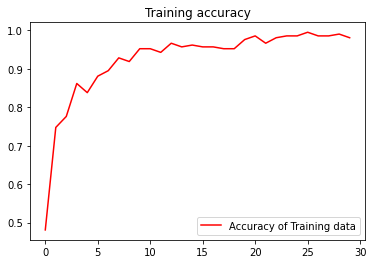

<Figure size 432x288 with 0 Axes>

In [15]:
''' plotting training accuracy graph '''
epochs = range(len(train_acc))
plt.plot(epochs, train_acc, 'r', label='Accuracy of Training data')
plt.title('Training accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()

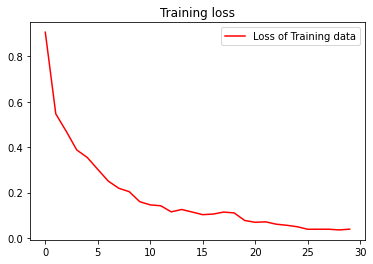

<Figure size 432x288 with 0 Axes>

In [16]:
''' plotting training loss graph '''
epochs = range(len(train_loss))
plt.plot(epochs, train_loss, 'r', label='Loss of Training data')
plt.title('Training loss')
plt.legend(loc=0)
plt.figure()
plt.show()

In [17]:
t_audio = []
t_labels = []

for audio,label in test_ds:
    t_audio.append(audio.numpy())
    t_labels.append(label.numpy())

t_audio = np.array(t_audio)
t_labels0 = np.array(t_labels)
t_labels0

array([0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 2, 0, 0, 2, 2, 0, 0, 2, 2, 0, 0, 0,
       0, 2, 2, 0, 0, 2, 2, 2, 2, 0, 2, 2, 2, 0, 0, 2, 2, 2, 0, 0, 0, 0,
       0, 2, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2, 0, 2, 0,
       0])

In [18]:
t_labels1=[]
for item in t_labels0:
    if item == 2:
        t_labels1+=[1]
    else:
        t_labels1+=[0]

np.array(t_labels1)

array([0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0,
       0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0,
       0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0,
       0])

In [19]:
print(t_audio.shape)
print(np.array(t_labels).shape)

(67, 2726, 129, 1)
(67,)


In [20]:
y_pred = np.argmax(model.predict(t_audio), axis=1)
y_true = np.array(t_labels1)
test_acc = sum(y_pred == y_true)/len(y_true)

print(test_acc)

0.8656716417910447


In [21]:
y_pred0=model.predict(t_audio)
y_pred=np.argmax(y_pred0,axis=1)
y_true = np.array(t_labels1)

print(classification_report(y_true,y_pred))

              precision    recall  f1-score   support

           0       0.89      0.87      0.88        39
           1       0.83      0.86      0.84        28

    accuracy                           0.87        67
   macro avg       0.86      0.86      0.86        67
weighted avg       0.87      0.87      0.87        67

